___
___
___


# **Datenanalyse & Forecasting Excercise 2025**

___
___
___



# **1. Introduction**

Welcome to our exercise notebook on data analysis and time series forecasting with sktime! This notebook will explore some tools for analyzing data and further show a small pipline approach to forecast future values. This notebook will provide you with some insights and hands-on experience in working with time series data. Therefore, let's get started and dive into the exciting world of data analysis and time series forecasting!

Please note it is mandatory to install all the required software and packages using the guide provided in Ilias before proceeding with this exercise notebook. The guide contains important instructions how to properly set up your environment. This ensures that all the necessary dependencies are installed. Failure to follow the instructions may result in errors or unexpected behavior while working through the notebook.

This is an interactive notebook and also includes some work assignments. Typical tasks are adding lines of code, documenting observations. Work orders are always marked in the color <span style="color:#A00000"> **red** </span>. We suggest you work in pairs or small groups so that you can share observations and discuss the tasks together.


___

## Agenda

1. Introduction, Agenda, learning goals and data loading

2. Data Analysis

3. Forecasting Excercise

4. Anomaly Detection

___


##  Learning goals (sorted by chapter)

### Learning goals data analysis and time series analysis

    - Enumerate different properties of time series e.g. seasonality    
    - Analyze energy time series and recognize and evaluate seasonal patterns
    - Derive and design appropriate calendrical features by considering seasonality and autocorellation function.


### Learning goals machine learning
    - Know basic Concepts of skTime
    
     

___



In [1]:
import pandas as pd
data = pd.read_csv('https://data.open-power-system-data.org/household_data/2020-04-15/household_data_60min_singleindex.csv', date_format='%Y-%m-%dT%H:%M:%SZ', index_col = "utc_timestamp", parse_dates=True , sep=',')
data.index = pd.to_datetime(data.index, utc=True)


## Data loading and first preprocessing
As a basis for the data analysis we need data in the first place. This publically available data set is described here: [Full Dataset Introduction](https://data.open-power-system-data.org/household_data/2020-04-15)

Here we have taken only a subset of the data, since we want to deal with only one building. Our choice is the industrial building 3. All the data is scaled in kWh. The building has an installed pv and an energy demand.



In [2]:
import statsmodels.api as sm
from matplotlib import pylab
from pylab import *


# Basic configuration to get beautiful pictures
pylab.rcParams['figure.figsize'] = (16, 9)

# Get the relevant data for this excercise and resample it to hourly resolution to save runtime complexity
data["demand"] = data["DE_KN_industrial3_grid_import"].diff(1)
data["solar"] = (data["DE_KN_industrial3_pv_facade"].diff(1) + data["DE_KN_industrial3_pv_roof"].diff(1))

# shift the index of the data by one interval to get the correct time alignment
data.index = data.index - pd.Timedelta(hours=1)

# Omit data without values
data = data[["demand","solar"]].dropna()
# Let the data start with a full day and end with a full day
data =  data[(data.index >= pd.to_datetime("2016-03-01",utc=True)) &  (data.index < pd.to_datetime("2017-05-01",utc=True))]
data = data.asfreq('1h')

# **2. Data Analysis**

<img src="https://imgs.xkcd.com/comics/data_trap.png" width="400" height="400">

[This xkcd comic you can find here](https://xkcd.com/2582/)

Within the data analysis chapter, we will first use simple tools from Pandas to get an overview of the data set.
After that, we will make a daily observation of the load and analyse the difference between a weekday and weekend.
In the last part we will use more complex tools like autocorellation plots and a seasonal decomposition to identify properties like trend and seasonality in our time series.

First of all, we would like to show you three very simple functions that Pandas has ready for you :

## Warmup and get familiar with the data

1. head() First five rows of the data set. Commonly used as a sanity check to see how the Data is constructed. [API](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html)
2. describe() Provides basic satistical values of the dataset. For example, mean, standard deviation and quantiles.[API](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)
3. plot() The plot function draws a simple plot over all collumns of the given dataset with mathplolib. [API](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

### <span style="color:#A00000"> Use the three functions (head, describe and plot) below! </span>



In [3]:
# Use the head function

data.head()

demand  solar
utc_timestamp                           
2016-03-01 00:00:00+00:00   62.00    0.0
2016-03-01 01:00:00+00:00   62.25    0.0
2016-03-01 02:00:00+00:00   61.75    0.0
2016-03-01 03:00:00+00:00   61.00    0.0
2016-03-01 04:00:00+00:00   61.25    0.0

In [4]:
# Use the describe function
data.describe()

demand         solar
count  10224.000000  10224.000000
mean      79.369383      2.199932
std       32.268000      3.833016
min       28.750000      0.000000
25%       57.250000      0.000000
50%       61.750000      0.027000
75%       95.250000      2.721500
max      222.500000     17.156000

 ### <span style="color:#A00000 "> Discuss in your group: </span>
 - <span style="color:#A00000 "> Based on these broad statistic, what would you infer about the house considered? </span>
 - <span style="color:#A00000 "> Do these statistics help you to get a feel for the data and what it looks like? </span>
 - <span style="color:#A00000 "> Does this data seem realistic? </span>
 - <span style="color:#A00000 "> Do you see any challanges? </span>
 - <span style="color:#A00000 "> How much data do we have? </span>

< Space for your answers>


<Axes: xlabel='utc_timestamp'>

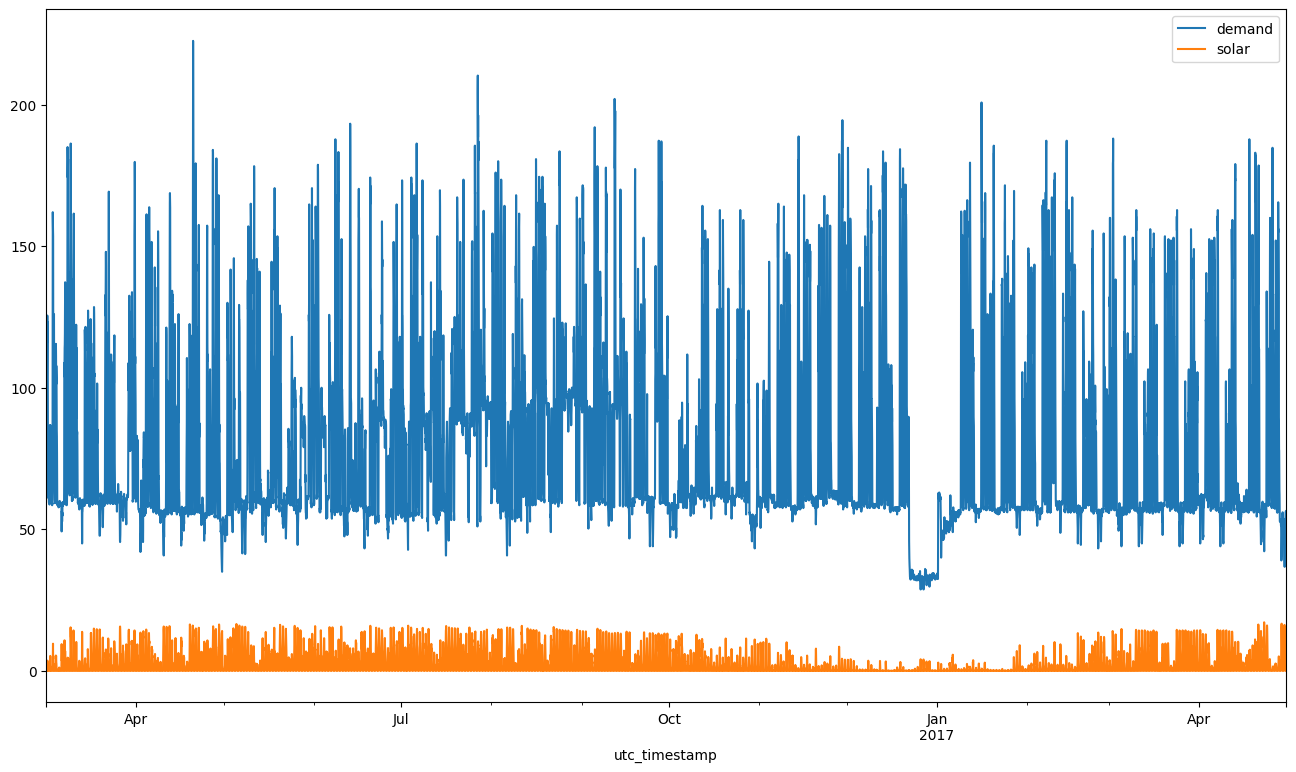

In [5]:
# Use the plot function
data.plot()

 ### <span style="color:#A00000 "> Point out two observations about the given data! </span>

1. < Observation 1 >
2. < Observation 2 >

 ### <span style="color:#A00000 "> Discuss in your group: </span>
 - <span style="color:#A00000 "> What did you find more beneficial, the statistics of the plots? </span>
 - <span style="color:#A00000 "> Do you see a benefit in both statstics and plots or would you only consider one of them? </span>

< Space for your answers>


## Daily observations

This part first shows an example of the pivot table how it is used to plot the data on daily basis. Further it extends by using the month attribute to plot the months in different plots. As you can see differnt days of the month are plotted.

In [6]:
# Calculating the hour of the day the weekday and the day since the beginning of the time series to create the pivot table
data["hour"] = data.index.hour.values
data["weekday"] = data.index.weekday.values
data["month"] = data.index.month.values
data["days_since_start"] = [int(x/(24)) for x in range(0,len(data))]

# creates the pivot table to get a table with the days since start in the columns and hours of the day as rows. For later usage the months are taken into account as the value parameter.
pivot_solar = pd.pivot_table(data, index=['hour'],columns=['days_since_start'], values=['solar','month'])
pivot_solar["solar"]


days_since_start    0      1      2      3      4      5       6      7    \
hour                                                                        
0                 0.000  0.000  0.000  0.000  0.000  0.000   0.000  0.000   
1                 0.000  0.000  0.000  0.000  0.000  0.000   0.000  0.000   
2                 0.000  0.000  0.000  0.000  0.000  0.000   0.000  0.000   
3                 0.000  0.000  0.000  0.000  0.000  0.000   0.000  0.000   
4                 0.000  0.000  0.000  0.006  0.000  0.000   0.002  0.006   
5                 0.000  0.205  0.547  0.681  0.061  0.053   0.502  0.488   
6                 0.031  0.990  1.666  3.859  0.275  0.670   4.348  1.636   
7                 0.089  2.198  3.267  5.347  0.381  3.276   8.972  3.198   
8                 0.275  2.625  7.981  5.131  0.529  9.446  10.793  2.095   
9                 0.437  3.438  9.597  4.209  0.898  5.063   6.957  2.883   
10                1.322  5.292  2.541  5.373  0.848  3.506   7.010  4.669   
11                3.615  4.852  2.375  5.170  1.163  6.199   6.803  3.722   
12                2.504  1.631  1.776  2.675  1.054  7.329   3.478  1.357   
13                1.105  1.508  2.416  2.632  1.082  3.960   7.014  3.182   
14                2.339  0.635  0.523  0.913  0.475  4.938   4.518  4.564   
15                0.673  0.021  0.482  0.151  0.101  0.720   1.152  1.358   
16                0.000  0.000  0.000  0.002  0.000  0.020   0.014  0.036   
17                0.000  0.000  0.000  0.000  0.000  0.000   0.000  0.000   
18                0.000  0.000  0.000  0.000  0.000  0.000   0.000  0.000   
19                0.000  0.000  0.000  0.000  0.000  0.000   0.000  0.000   
20                0.000  0.000  0.000  0.000  0.000  0.000   0.000  0.000   
21                0.000  0.000  0.000  0.000  0.000  0.000   0.000  0.000   
22                0.000  0.000  0.000  0.000  0.000  0.000   0.000  0.000   
23                0.000  0.000  0.000  0.000  0.000  0.000   0.000  0.000   

days_since_start     8       9    ...     416     417     418     419    420  \
hour                              ...                                          
0                  0.000   0.000  ...   0.000   0.000   0.000   0.000  0.000   
1                  0.000   0.000  ...   0.000   0.000   0.000   0.000  0.000   
2                  0.000   0.000  ...   0.000   0.000   0.000   0.000  0.000   
3                  0.000   0.000  ...   0.084   0.106   0.102   0.124  0.015   
4                  0.004   0.000  ...   1.463   1.528   1.040   1.672  0.211   
5                  0.307   0.224  ...   4.247   4.167   3.476   4.354  1.295   
6                  1.489   0.840  ...   7.392   7.109   4.709   7.243  2.249   
7                  1.906   2.103  ...   8.559  10.754   7.035  12.203  2.837   
8                  4.535   3.266  ...  12.472  14.089  11.293  14.811  2.723   
9                  7.348  11.297  ...  15.828   8.261  14.283  15.930  4.159   
10                15.367  14.286  ...  16.363  12.098  17.156  16.053  2.508   
11                11.998  13.386  ...  15.215  12.023  15.811  15.000  2.100   
12                11.932  11.087  ...  13.432  10.330  13.459  12.652  1.830   
13                 8.898   8.231  ...   8.500   3.773   8.396   8.060  1.144   
14                 4.834   4.493  ...   5.512   1.833   5.521   5.614  0.733   
15                 1.059   1.071  ...   2.566   0.766   2.673   2.557  0.286   
16                 0.020   0.047  ...   0.816   0.136   0.699   0.835  0.062   
17                 0.000   0.000  ...   0.035   0.011   0.040   0.067  0.000   
18                 0.000   0.000  ...   0.000   0.000   0.000   0.000  0.000   
19                 0.000   0.000  ...   0.000   0.000   0.000   0.000  0.000   
20                 0.000   0.000  ...   0.000   0.000   0.000   0.000  0.000   
21                 0.000   0.000  ...   0.000   0.000   0.000   0.000  0.000   
22                 0.000   0.000  ...   0.000   0.000   0.000   0.000  0.000 

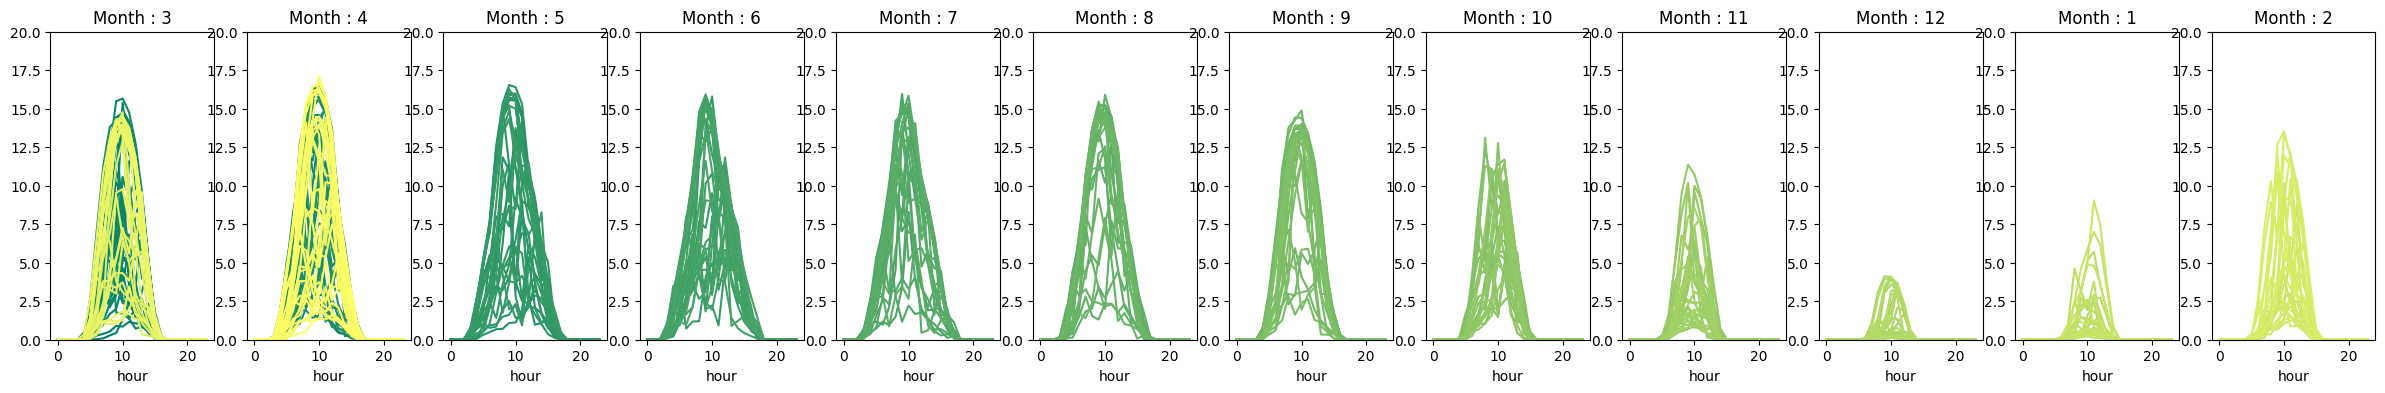

In [7]:
fig, ax = plt.subplots(1,len(data["month"].unique()))
for i in range(len(data["month"].unique())):
    pivot_solar[pivot_solar["month"]==data["month"].unique()[i]]["solar"].plot(ax=ax[i],figsize=(30, 4), layout= (7,1),ylim = (0,20),legend=False, colormap="summer", title="Month : " + str(data["month"].unique()[i]))

 ### <span style="color:#A00000 "> Discuss in your group: </span>
 - <span style="color:#A00000 "> What do you observe during the different months ? </span>

### Workingdays

 ### <span style="color:#A00000 "> Plot only the working days (i.e. Monday-Friday):</span>
 - <span style="color:#A00000 ">The aim is to first filter the data to only get the days from Monday to Friday.</span>
 - <span style="color:#A00000 ">Create a variable ``working_day_data`` and use the weekday column in ``data`` to select the working days. The weekday column is enumerated from 0-6 with 0 being monday and 6 sunday. Therefore working days are the days with a weekday value smaller than five. You can select a column in pandas with ``data["column_name"]`` and if you want to select a subset of the data based on the value in this column you need to use the syntax ``data[data["column_name"] * x]``, where ``*`` indicates a mathematical operater such as ``<`` and ``x`` is the condition. For example, to only select Tuesday you would use ``tuesday_data = data[data["weekday"] == 1]``.</span>
 - <span style="color:#A00000 ">Create the pivot table similar to the example above using the function pivot_table from pandas! [API](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html). Make sure you use the filtered ``working_day_data`` variable created above.</span>
 - <span style="color:#A00000 ">Extend the pivot table to plot working days. Use "days_since_start" as ``columms``, "hour" as ``index`` and "demand" as ``values``!</span>

<Axes: xlabel='hour'>

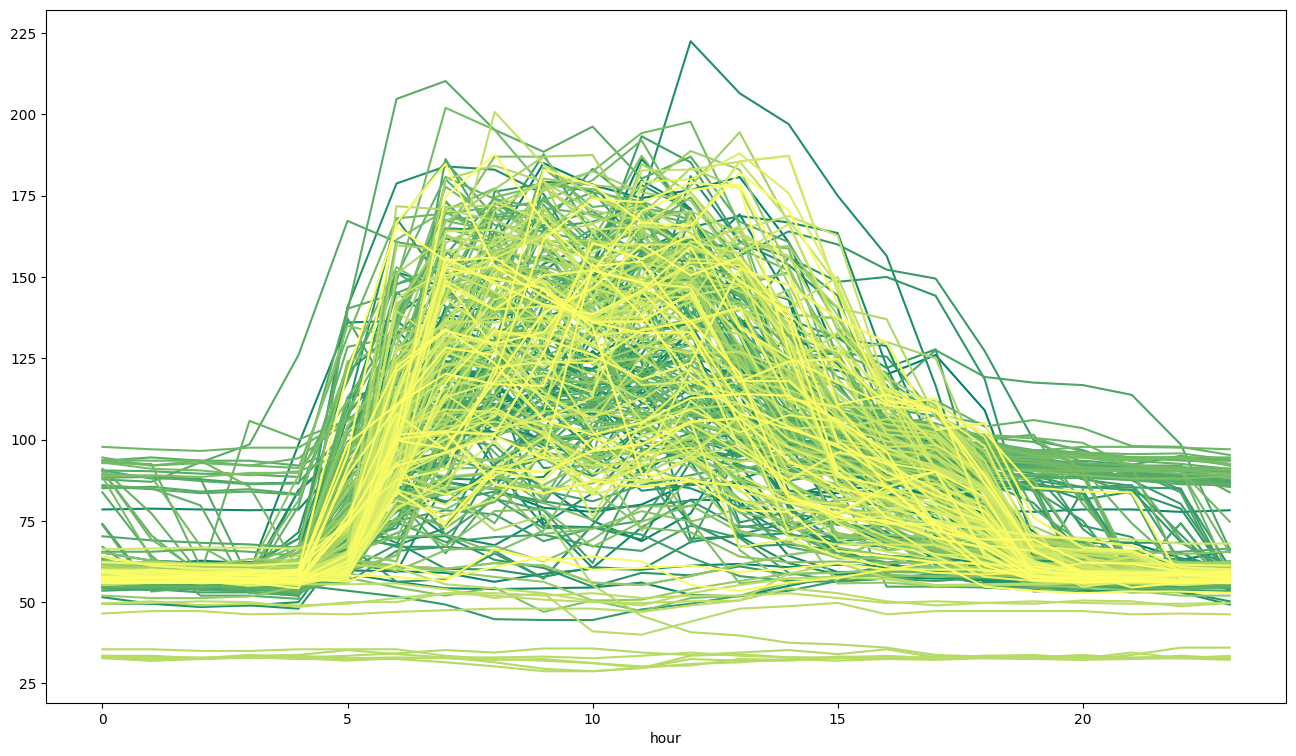

In [8]:

# this get's gapped
working_day_data = data[data["weekday"] < 5]
pivot_workingdays = pd.pivot_table(working_day_data, index=['hour'],columns=['days_since_start'], values=['demand'])

# plots the data
pivot_workingdays["demand"].plot(legend=False,colormap="summer")



### Weekend

 ### <span style="color:#A00000 "> Plot the weekends:</span>
 - <span style="color:#A00000 ">Repeat the task above, but this time only select the weekends (remember weekday is enumerated from 0-6, with 0 being Monday).</span>

<Axes: xlabel='hour'>

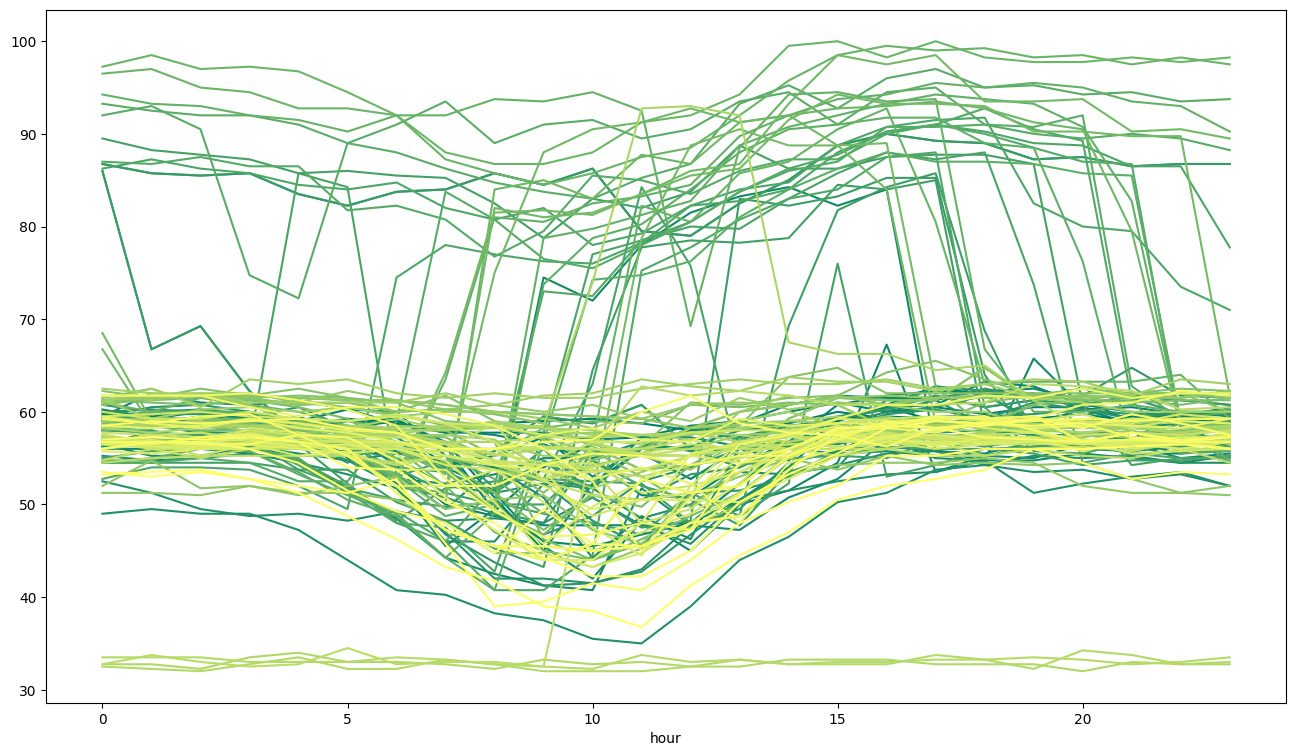

In [9]:

# this get's gapped
weekday_data = data[data["weekday"] >= 5]
pivot_weekends = pd.pivot_table(weekday_data, index=['hour'],columns=['days_since_start'], values=['demand'])
pivot_weekends["demand"].plot(legend=False,colormap="summer")


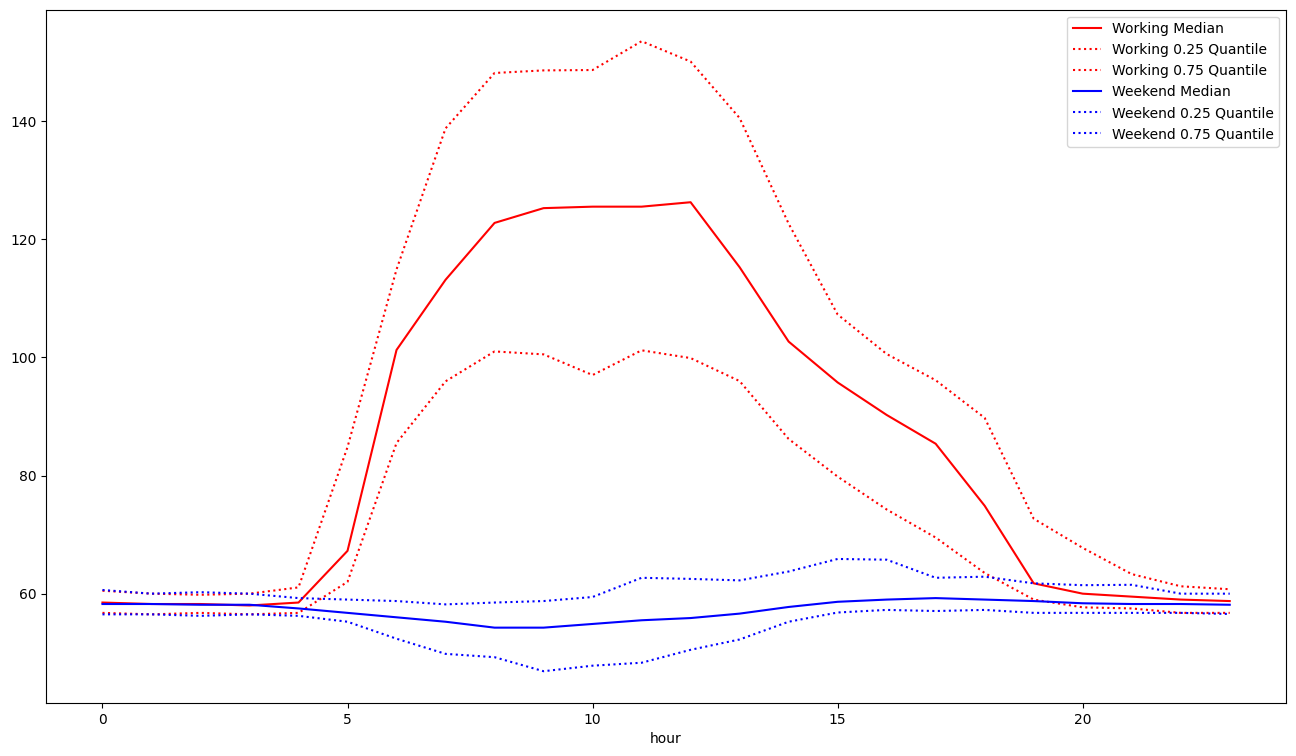

In [10]:
#
# Plot the median of all weekdays
#

pivot_workingdays.median(axis=1).plot(color="red", label="Working Median")
pivot_workingdays.quantile(0.25,axis=1).plot(color="red",linestyle='dotted', label="Working 0.25 Quantile")
pivot_workingdays.quantile(0.75,axis=1).plot(color="red",linestyle='dotted', label="Working 0.75 Quantile")
pivot_weekends.median(axis=1).plot(color="blue", label="Weekend Median")
pivot_weekends.quantile(0.25,axis=1).plot(color="blue",linestyle='dotted', label="Weekend 0.25 Quantile")
pivot_weekends.quantile(0.75,axis=1).plot(color="blue",linestyle='dotted', label="Weekend 0.75 Quantile")
plt.legend()

 ### <span style="color:#A00000 "> Discuss in your group:</span>
 - <span style="color:#A00000 "> Do these different plots (weekdays, weekends, median) fit your expectations?</span>
 - <span style="color:#A00000 "> What could explain the pattern for this building for a weekday? </span>
 - <span style="color:#A00000 "> Could you interfer the base load of the building by looking at the daily observation plots? </span>
 - <span style="color:#A00000 "> How could explain the higher variance of weekdays in contrast to weekends? </span>
 - <span style="color:#A00000 "> Based on these observations, what features would you consider extracting or engineering for a forecasting task? </span>

< Space for your answers>


## Autorcorrelation Function and Seasonal Decomposition

### Autocorrelation Function Plot


The autocorrelation function (ACF) is a statistical technique that we can use to identify how correlated the values in a time series are with each other. The ACF plots the correlation coefficient against the lag, which is measured in terms of a number of periods or units. [Explanation from here](https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling#:~:text=The%20autocorrelation%20function%20(ACF)%20is,number%20of%20periods%20or%20units.)

An detailed expleanation is here: [Autocorrelation](https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/time-series/how-to/autocorrelation/interpret-the-results/autocorrelation-function-acf/)

API-Statsmodels [API](https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.acf.html)

### Seasonal Decomposition

An detailed explaination about the used seasonal decomposition can be found here: [API](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)

The additive model which is used here is defined as $Y[t] = T[t] + S[t] + e[t]$.

The results are obtained by first estimating the trend by applying a convolution filter to the data. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component.

#### Demand ACF and Seasonal Decomposition

 ### <span style="color:#A00000 "> Play around with autocorrelation: </span>
- <span style="color:#A00000 "> Use the ``sm.tsa.graphics.plot_acf(x, lags=None)`` function to plot the autocorrelation function of ``data["demand"]``. </span>
- <span style="color:#A00000 "> Play around with a different number of lags, i.e. 5, 24, 200. </span>
- <span style="color:#A00000 "> What do you observe? </span>

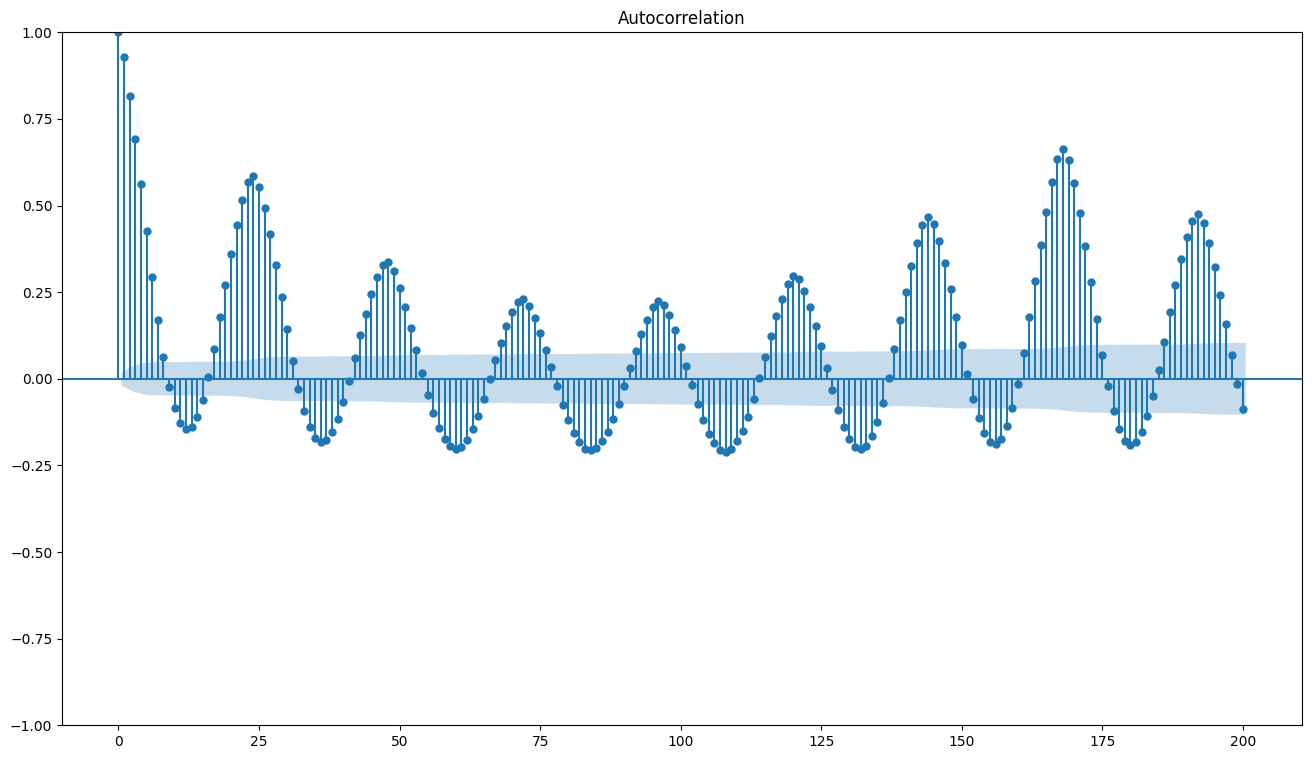

In [11]:
sm.tsa.graphics.plot_acf(data["demand"], lags= 200);

 ### <span style="color:#A00000 "> Play around with seasonal decomposition: </span>
- <span style="color:#A00000 "> Use the ``sm.tsa.seasonal_decompose(x, period=None)`` function to create a seasonal decomposition of ``data["demand"]``. </span>
- <span style="color:#A00000 "> Visualise this decomposition with ``sm.tsa.seasonal_decompose().plot()``. </span>
- <span style="color:#A00000 "> Adjust the ''period'' parameter of the function, try for example 24 (a day), or 168 (a week), or something random (e.g. 77). </span>
- <span style="color:#A00000 "> What do you observe? </span>

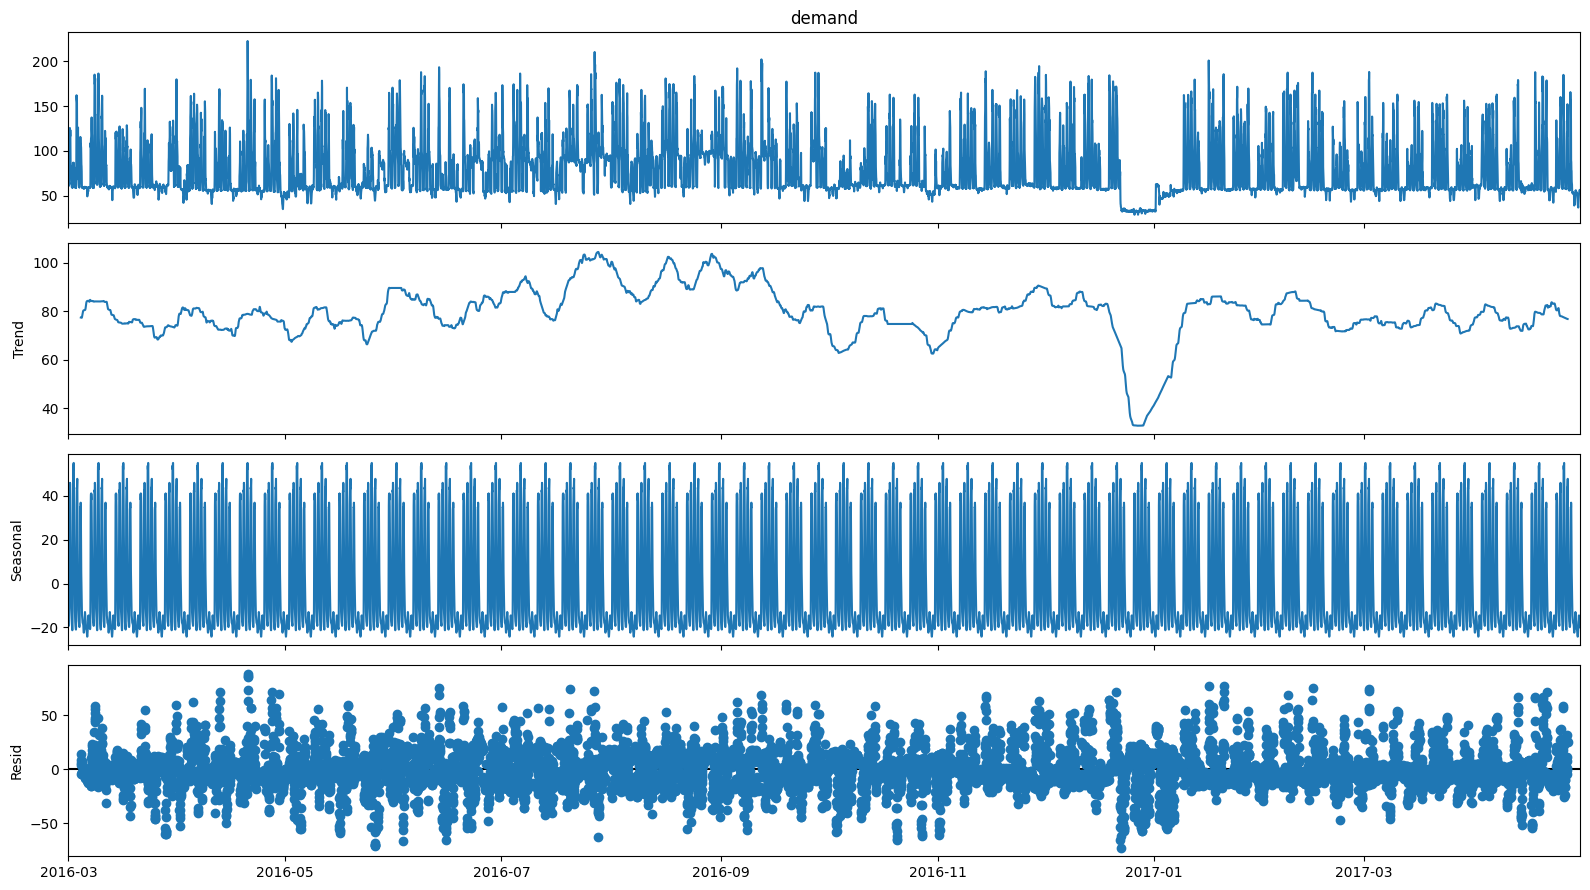

In [12]:
# do seasonal decomposition of demand here
# this get's gapped
sm.tsa.seasonal_decompose(data["demand"], period=24 * 7 ).plot();


### ACF and Seasonal Decomposition Solar

 ### <span style="color:#A00000 "> Repeat the above two tasks for the solar data! </span>

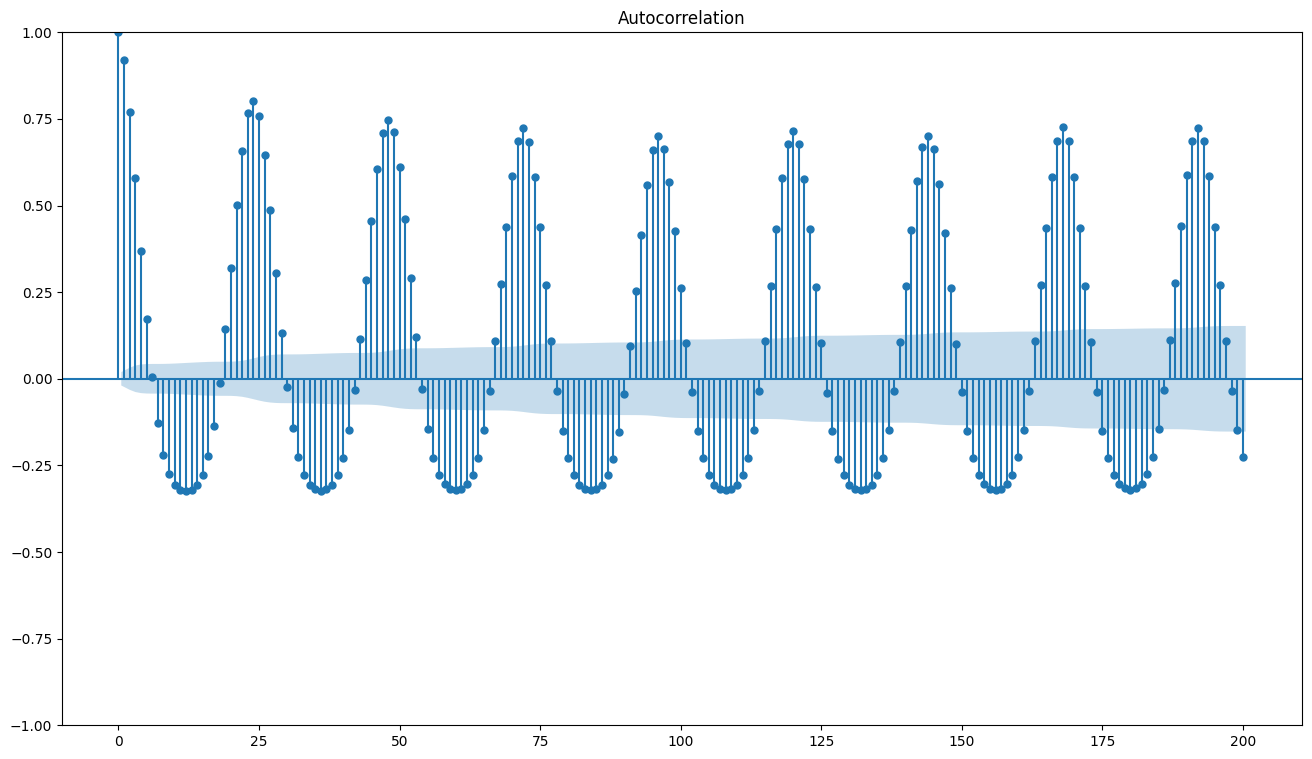

In [13]:
# do seasonale decomposition on solar data (data["solar"])
# Gap here for acf
sm.tsa.graphics.plot_acf(data["solar"], lags= 200);

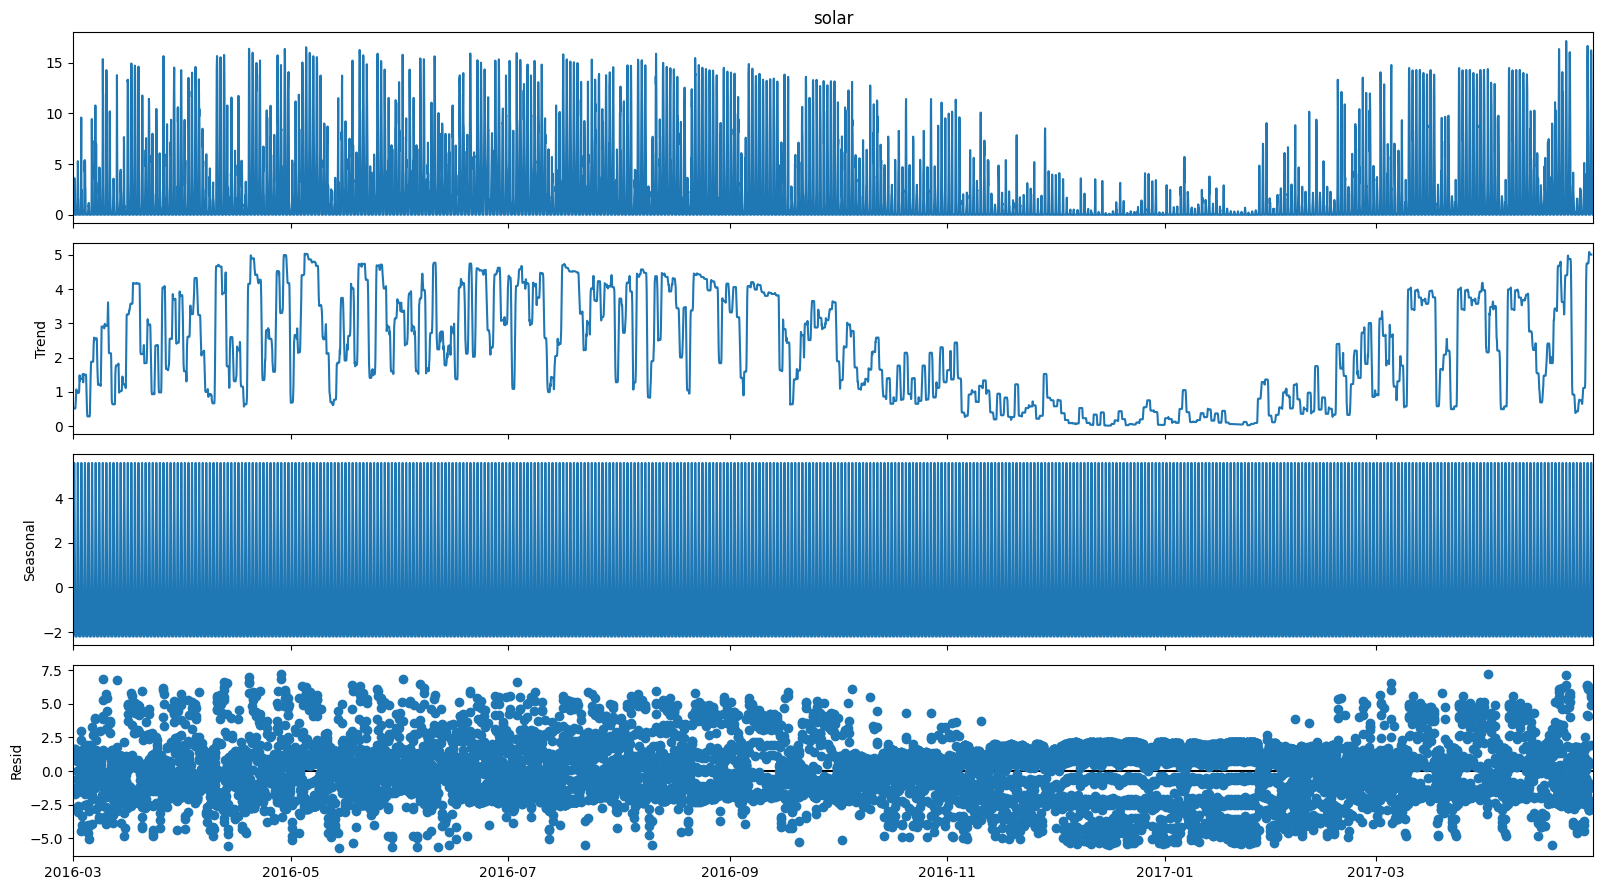

In [14]:
# do seasonal decomposition of demand here
# this get's gapped
sm.tsa.seasonal_decompose(data["solar"], period=24).plot();


# <span style="color:#A00000 ">  STOP HERE - We want to discuss some things together before going on </span>

# **3. Forecasting Exercise**

In this section of the Jupyter Notebook, you will learn how to use **[sktime](https://www.sktime.net/en/stable/)** for time series forecasting.

Time series forecasting is a technique used to predict future values of a variable based on historical data — and optionally known exogenous variables.  
It is widely used in areas such as:

- Finance  
- Economics  
- Engineering  
- **Energy Informatics**

---

## 🔗 Useful Resources

- 📘 **Basic sktime API description:**  
  [sktime API](https://www.sktime.net/en/stable/)

- 🔮 **List of available forecasters:**  
  [Forecaster Overview](https://www.sktime.net/en/stable/estimator_overview.html#filter=all&tags=%7B%7D)

- ⏳ **Forecasting Horizon documentation:**  
  [ForecastingHorizon](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.base.ForecastingHorizon.html)

- 🧩 **ExpandingWindowSplitter (for cross-validation):**  
  [ExpandingWindowSplitter](https://www.sktime.net/en/v0.21.0/api_reference/auto_generated/sktime.forecasting.model_selection.ExpandingWindowSplitter.html)

---

## 📊 Time Series Specific - Expanding Window Splitter Illustration

    Fold 1:  *  *  *  *  *  x  x  x  -  -  -
    Fold 2:  *  *  *  *  *  *  x  x  x  -  -
    Fold 3:  *  *  *  *  *  *  *  x  x  x  -
    Fold 4:  *  *  *  *  *  *  *  *  x  x  x
             |  |  |  |  |  |  |  |  |  |  |
    Pos:     1  2  3  4  5  6  7  8  9 10 11

**Legend:**

- `*` → Training window  
- `x` → Forecasting horizon (test window)  
- `-` → Future/unseen data  
- Each row is a fold in cross-validation using an expanding window.
- The training section expands while the test window slides forward.

## 🧪 Exercises

The following exercises will guide you through creating a simple time series forecast using **sktime**.

You will apply a **basic sktime forecasting workflow** to data already introduced in the previous exercise.


## 🔍 Let's Look at What We Prepared

### 📊 Data

We use the data from the previous exercise part.

---

### 📏 Metrics

To evaluate the accuracy of the forecast, this section introduces various metrics such as:

- **Mean Absolute Percentage Error (MAPE)**
- **Mean Absolute Error (MAE)**
- **Mean Squared Error (MSE)**

These metrics help you understand how close the forecasted values are to the actual values.

Mathematical definitions:

- $ \text{MAPE} = \frac{1}{n} \sum_{t=1}^{n} \left| \frac{A_t - F_t}{A_t} \right| $
- $ \text{MAE} = \frac{1}{n} \sum_{t=1}^{n} \left| A_t - F_t \right| $
- $ \text{MSE} = \frac{1}{n} \sum_{t=1}^{n} \left( A_t - F_t \right)^2 $

> 🔴 **What are these metrics sensitive to?**  
> Consider how each one reacts to outliers, scale, or percentage errors.

---

### 🤖 Model: N-HiTS (Neural Hierarchical Interpolation for Time Series Forecasting)

In this section, we introduce **[N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting](https://arxiv.org/abs/2201.12886)** (Challu et al., 2022), an advanced deep learning architecture developed for **univariate time series forecasting**.


---

### 📈 Visualization

To help interpret the results, we include visualizations that compare **forecasted values** to **actual values** over time.

These visualizations help identify:

- Trends
- Seasonal patterns
- Anomalies or mismatches between forecast and ground truth

---

### ✅ Summary

This section provides a **practical introduction** to using `sktime` for time series forecasting.  
By the end, you will have understood how to:

- Apply a basic forecasting model
- Evaluate its performance using multiple metrics
- Visualize the results for better interpretation


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='demand'>)

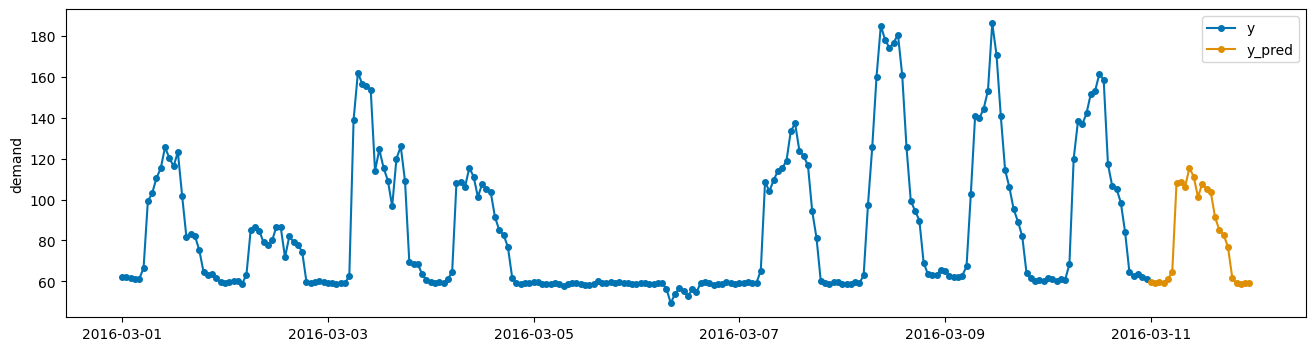

In [15]:
from sklearn.preprocessing import StandardScaler

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.pytorchforecasting import PytorchForecastingNHiTS
from sktime.forecasting.arima import AutoARIMA

from sktime.utils.plotting import plot_series , plot_windows
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter

from sktime.performance_metrics.forecasting import MeanAbsoluteError , MeanSquaredError , MeanAbsolutePercentageError
import warnings


#
# Needed as sktime throws a lot of exceptions
#

warnings.filterwarnings("ignore")


#
# Dummy Demonstration How the basic sktime workflow for prediction works within a naive forecaster 
#


# step 1: data specification
y = data["demand"][:24*10] 
# step 2: specifying forecasting horizon
fh = np.arange(1, 25)
# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=24*7)
# step 4: fitting the forecaster
forecaster.fit(y)
# step 5: querying predictions
y_pred = forecaster.predict(fh)
# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])


In [16]:
#
# HELPER METHODS BLOCK Do not change this block
#

from ipywidgets import interact, IntSlider, fixed


def plot_forecasts_for_day(models_dict, day):
    """
    Plot forecasts for a given day, using the native timestamp index from y_test.

    Args:
        models_dict (dict): Keys are model names, values are DataFrames with 'y_pred' and 'y_test'.
        day (int): Day index (1-based).
    """
    first_df = next(iter(models_dict.values()))
    y_true = first_df.iloc[day - 1]["y_test"]

    x = y_true.index
    y_true = np.array(y_true)

    plt.figure(figsize=(12, 5))
    plt.plot(x, y_true, label="y (True)", linewidth=2)

    for label, df in models_dict.items():
        y_pred = df.iloc[day - 1]["y_pred"]
        if hasattr(y_pred, "index"):
            y_pred = np.array(y_pred)
        plt.plot(x, y_pred, label=label, linestyle="--")

    plt.title(f"Forecast Comparison – {x[0].date()}")
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def interactive_forecast_plot(models_dict):
    """
    Interactive slider to browse forecast plots per day using existing timestamped y_test.
    """
    num_days = len(next(iter(models_dict.values())))

    interact(
        plot_forecasts_for_day,
        models_dict=fixed(models_dict),
        day=IntSlider(min=1, max=num_days, step=1, value=1, description="Day")
    )
#
#
#

def plot_full_forecast_series(models_dict):
    """
    Plot the full time series of y_test and all y_pred across all days, using native timestamps.

    Assumes y_test and y_pred in each row are pandas Series (with DateTimeIndex).
    """
    # Get full y_true time series
    first_df = next(iter(models_dict.values()))
    y_true_series = pd.concat(first_df["y_test"].values)

    plt.figure(figsize=(14, 5))
    plt.plot(y_true_series.index, y_true_series.values, label="y (True)", linewidth=2)

    # Plot all model predictions
    for label, df in models_dict.items():
        y_pred_series = pd.concat(df["y_pred"].values)
        plt.plot(y_pred_series.index, y_pred_series.values, label=label, linestyle="--")

    plt.title("Full Forecast Series Over Time")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()


#
# Summary Metrics Function
#

def summarize_metrics(models_dict, prefix="test_"):
    """
    Generate an evaluation table from precomputed test metrics in the DataFrames.

    Args:
        models_dict (dict): Dictionary with model names as keys and DataFrames as values.
                            Each DataFrame should contain columns like 'test_MAE', 'test_MSE', etc.
        prefix (str): Prefix of metric columns (default is 'test_').

    Returns:
        pd.DataFrame: Evaluation table with models as rows and metrics as columns (mean per metric).
    """
    results = {}

    for label, df in models_dict.items():
        # Select only columns with the given prefix
        metric_cols = [col for col in df.columns if col.startswith(prefix)]
        
        # Remove the prefix in column names
        renamed_metrics = {col: col[len(prefix):] for col in metric_cols}
        
        # Compute mean for each metric
        means = df[metric_cols].mean().rename(index=renamed_metrics)
        
        results[label] = means

    # sort by the first metric
    df_res = pd.DataFrame.from_dict(results, orient="index").round(4)
    df_res = df_res.sort_values(by=df_res.columns[0], ascending=True)

    return df_res

#
# Helper Methods End
#

### <span style="color:#A00000 "> Discuss with your group: </span>
- <span style="color:#A00000 "> Discuss what the naiv forecaster does? </span>
- <span style="color:#A00000 "> Why could a navie forecaster could be useful?</span>
- <span style="color:#A00000 "> What is the basic assumption behind a naive forecaster?</span>
- <span style="color:#A00000 "> Where a naive forecaster fails and why?</span>
- <span style="color:#A00000 "> How can other forecaster prevent this?</span>

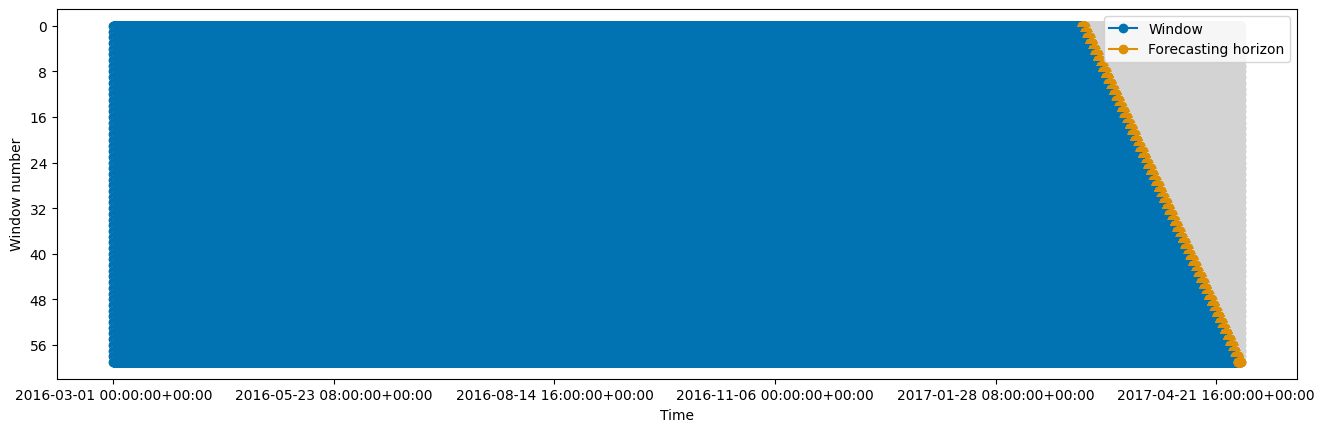

In [17]:
y = data["demand"]

TRAINING_LENGTH = 366 * 24 # Because 2016 was a leap year, we use 366 days of hourly data

cv = ExpandingWindowSplitter(
    step_length=24, fh=[i for i in range(1,25)], initial_window=TRAINING_LENGTH
)

plot_windows(cv=cv, y=y)

metrics = [MeanAbsolutePercentageError(), MeanAbsoluteError(), MeanSquaredError()]
# build up a dictionary to store the results
result_dict = {}

In [18]:
from pytorch_forecasting.metrics import (
    MAPE
)

#
# Forecaster Evaluation
#

#
#   NaiveForecaster
#

forecaster_naive = NaiveForecaster(strategy="last", sp= 24 * 7)
df_naiv_168 = evaluate(forecaster=forecaster_naive, y=y, cv=cv, return_data=True,scoring=metrics)
result_dict["NaiveForecaster"] = df_naiv_168


#
#   NHits
#
  
forecaster_nhits = StandardScaler() * PytorchForecastingNHiTS(
    model_params={
        "context_length": 24 * 7,
        "prediction_length": 24,
        },
    trainer_params={
        "max_epochs": 10,
    },
    dataset_params={
        "max_encoder_length": 24 * 7,  # Context length
        "max_prediction_length": 24,    # Prediction length
    }
)


df_nhits = evaluate(forecaster=forecaster_nhits, y=y, cv=cv,return_data=True, return_model=True, strategy="no-update_params",scoring=metrics)
result_dict["NHits"] = df_nhits



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-07-01 13:28:26.283020: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-01 13:28:26.2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/home/ws/hp5743/miniconda3/envs/excercise_2025/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:656: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ws/hp5743/miniconda3/envs/excercise_2025/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:656: FutureWarning: Downcas

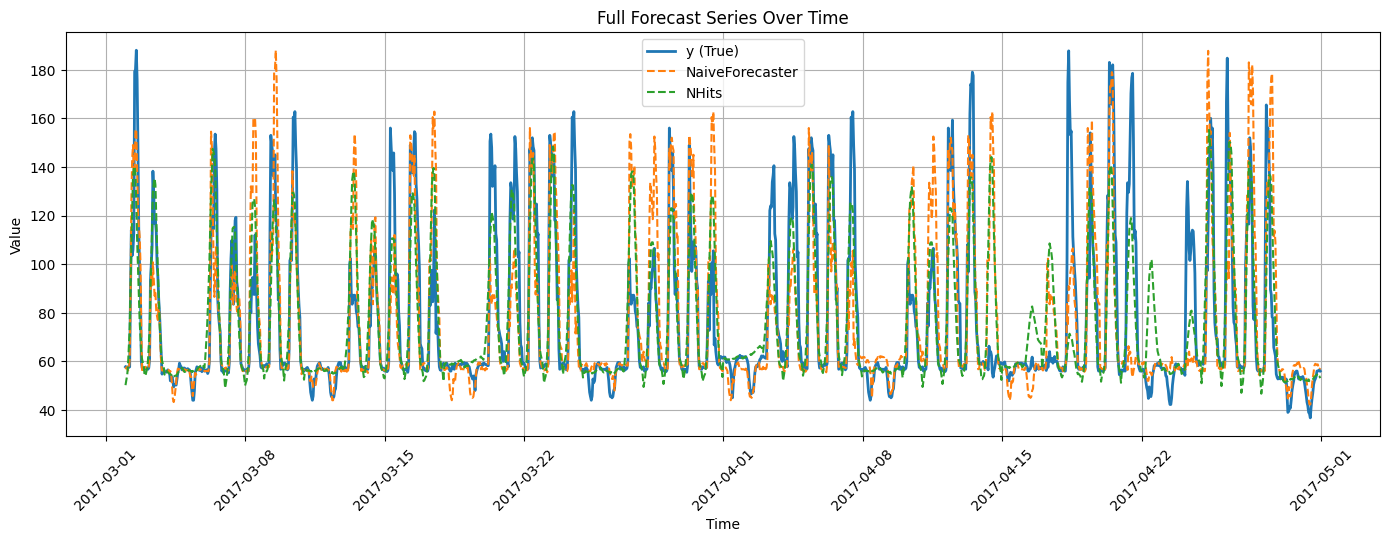

In [19]:
plot_full_forecast_series(result_dict)

In [20]:
#interactive_forecast_plot(result_dict)

In [21]:
summarize_metrics(result_dict, prefix="test_")

MeanAbsolutePercentageError  MeanAbsoluteError  \
NHits                                 0.1367            11.5192   
NaiveForecaster                       0.1455            13.2422   

                 MeanSquaredError  
NHits                    358.0935  
NaiveForecaster          548.2231

# Enrich the forecast with features

We ob



Information about the features can be found [here](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.series.date.DateTimeFeatures.html).

In [22]:

from sktime.transformations.series.date import DateTimeFeatures
from sktime.transformations.series.holiday import HolidayFeatures
from holidays import country_holidays

holiday_transformer = HolidayFeatures(
   calendar=country_holidays(country="DE",state="BW"),
   include_bridge_days=True,
   )  
X_holiday = holiday_transformer.fit_transform(y)
X_holiday["holiday"] = X_holiday.sum(axis=1)


calendar_transformer = DateTimeFeatures(ts_freq="H", manual_selection=["day_of_week","hour_of_day"])
X_calendar = calendar_transformer.fit_transform(y)

#join them together as a feature matrix

X = pd.concat([X_holiday["holiday"], X_calendar], axis=1)


/home/ws/hp5743/miniconda3/envs/excercise_2025/lib/python3.11/site-packages/sktime/transformations/series/date.py:451: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(
/home/ws/hp5743/miniconda3/envs/excercise_2025/lib/python3.11/site-packages/sktime/transformations/series/date.py:451: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(


In [23]:
#
#   NHiTS with Features
#  
forecaster_nhits_features = StandardScaler() * PytorchForecastingNHiTS(
    model_params={
        "context_length": 24 * 7,
        "prediction_length": 24, # Example parameter, adjust as needed
        },
    trainer_params={
        "max_epochs": 10,
    },
    dataset_params={
        "max_encoder_length": 24 * 7,  # Context length
        "max_prediction_length": 24,    # Prediction length
    }
)
df_nhits_features = evaluate(forecaster=forecaster_nhits_features,y=y,X=X,cv=cv,return_data=True, strategy="no-update_params",scoring=metrics)
result_dict["NHits with Calendaric Features"] = df_nhits_features



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | QuantileLoss   | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 2.1 M  | train
-----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.586     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/home/ws/hp5743/miniconda3/envs/excercise_2025/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:656: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ws/hp5743/miniconda3/envs/excercise_2025/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:656: FutureWarning: Downcas

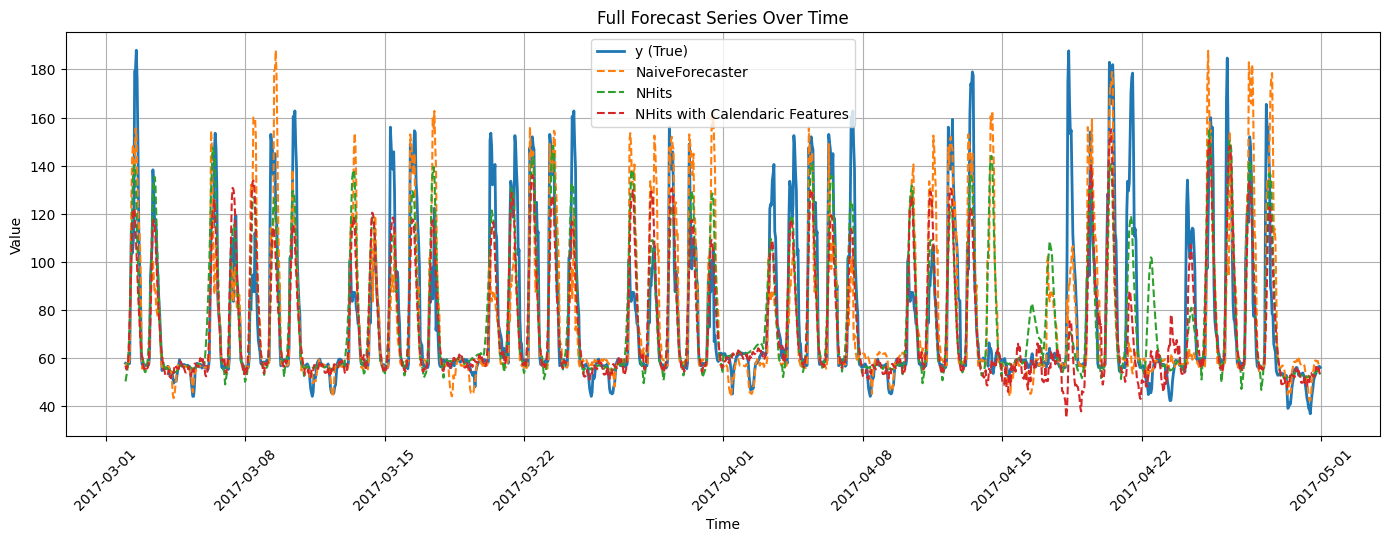

In [24]:
plot_full_forecast_series(result_dict)

In [25]:
#interactive_forecast_plot(result_dict)

In [26]:
summarize_metrics(result_dict, prefix="test_")

MeanAbsolutePercentageError  \
NHits with Calendaric Features                       0.1211   
NHits                                                0.1367   
NaiveForecaster                                      0.1455   

                                MeanAbsoluteError  MeanSquaredError  
NHits with Calendaric Features            11.0307          353.2198  
NHits                                     11.5192          358.0935  
NaiveForecaster                           13.2422          548.2231

## <span style="color:#A00000 "> Now you can play! </span>
- <span style="color:#A00000 "> Play around with the forecast horizon and the number of historical features.</span>
- <span style="color:#A00000 "> You can also try altering the scope variable being forecast.</span>
- <span style="color:#A00000 "> How do the results change?</span>
- <span style="color:#A00000 "> Which forecasters perform best?</span>


<img src="https://imgs.xkcd.com/comics/machine_learning.png" width="600" height="800">

[This xkcd comic you can find here](https://xkcd.com/1838/)

# Excercise Anomaly Detection

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sktime.detection.lof import SubLOF

cutoff = 250 * 24  # 200 days of hourly data

# --- Prepare data ---
X_train = data[["demand"]][:cutoff]  # Training data
X_test = data[["demand"]][cutoff:]   # Data for anomaly detection

# --- Apply SubLOF ---
model = SubLOF(n_neighbors=20, window_size=168, novelty=True)
model.fit(X_train)  # Train on normal data

# Predict anomalies on new data
labels = model.predict_segments(X_test) 
labels = model.segments_to_change_points(labels)


# Combine with test data
data_with_anomalies = X_test.copy()
data_with_anomalies["anomaly"] = 0
# --- Plot results ---
plt.figure(figsize=(14, 7))
plt.plot(data_with_anomalies.index, data_with_anomalies["demand"], label="Demand", color='blue')
plt.scatter(data_with_anomalies.index[data_with_anomalies["anomaly"] == 1],
            data_with_anomalies["demand"][data_with_anomalies["anomaly"] == 1],
            color='red', label='Anomaly', marker='o')
plt.title("Anomaly Detection in Demand Data")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.legend()
plt.tight_layout()
plt.show()



AttributeError: 'Index' object has no attribute 'iloc'

In [ ]:
from sktime.detection.lof import SubLOF
from sktime.transformations.series.detrend import Detrender
pipeline = Detrender() * SubLOF(n_neighbors=5, window_size=5, novelty=True)
pipeline.fit(x)
DetectorPipeline(...)
y_hat = pipeline.transform(x)

In [64]:
labels

Index([ 0,  4,  6,  7,  8, 13, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       31, 32, 33, 34, 35, 36, 37, 38, 42, 43, 44, 45, 46, 47],
      dtype='int64')